In [1196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git, os, requests, json
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from scipy.optimize import curve_fit
from scipy.special import factorial

# Loading data, creation of basic features

In [1322]:
years = [2017, 2018, 2019, 2020]
raw_data_allyears = []
people_allyears = []
for year in years:
    current_raw_data = pd.read_csv('rumors/data/rm'+str(year)+'.csv',sep=',',encoding='latin')
    raw_data_allyears.append(current_raw_data)
    people_allyears.append(current_raw_data.sort_values(['Inspire link'])['Inspire link'].unique())

In [81]:
statuses = np.copy(raw_data['Status'].unique())
statuses_clean = []

In [82]:
for status in statuses:
    if status == 'Offered': statuses_clean.append('Offered')
    elif status == 'Accepted': statuses_clean.append('Accepted')
    elif status == 'Declined': statuses_clean.append('Declined')
    elif status.find('Offered')>0: statuses_clean.append('Offered, Special')
    elif status.find('Accepted')>0: statuses_clean.append('Accepted, Special')
    elif status.find('Declined')>0: statuses_clean.append('Declined, Special') 
    else: statuses_clean.append('Unreadable')

In [83]:
status_dict=dict(zip(statuses,statuses_clean))

In [484]:
len(raw_data[raw_data['Inspire link']==people[0]]['Institution'].unique())

2

In [88]:
number_of_offers = [len(raw_data[raw_data['Inspire link']==person]['Institution'].unique()) for person in people]

In [290]:
data = pd.DataFrame(people,columns=['Person'])

In [799]:
inspire_data = []
for person in people:
    response = requests.get(f"http://old.inspirehep.net/search?p=ea:{person}&rg=75&of=recjson&ot=recid,creation_date,number_of_authors,number_of_citations,authors")
    inspire_data.append(json.loads(response.text))

In [800]:
paper_series = pd.Series(dict(zip(people,inspire_data)))

In [983]:
def analyze(person):
    return_dict = {}
    frame_incl_recent = pd.DataFrame(paper_series[person],columns=['creation_date','number_of_authors','number_of_citations'])
    frame = frame_incl_recent[pd.to_datetime(frame_incl_recent['creation_date']) < pd.to_datetime('01/01/2020')]
    
    paper_dates = np.array([pd.to_datetime(paper['creation_date']) for paper in paper_series[person]])
    
    author_lists = [paper['authors'] for paper in paper_series[person]]
    affiliations = []
    
    for author_list in author_lists:

        author_frame = pd.DataFrame(author_list)
        try: 
            affiliation = author_frame[author_frame['full_name'].str.contains(person.split('.')[-2])]['affiliation'].values
            if type(affiliation) == str:
                affiliations.append(affiliation.lower().strip())
            else:
                for aff in affiliation: affiliations.append(aff.lower().replace('(main)','').strip())
        except: continue 

            
    #affiliations = np.array(affiliations).flatten()
    
    return_dict['papers_total'] = len(frame)
    return_dict['citations_total'] = frame['number_of_citations'].sum()
    return_dict['citations_median'] = frame['number_of_citations'].median()
    return_dict['citations_max'] = frame['number_of_citations'].max()
    return_dict['collaboration'] = frame['number_of_authors'].max()>15
    return_dict['offers'] = len(raw_data[raw_data['Inspire link']==person]['Institution'].unique())
    return_dict['citations_per_paper'] = frame['number_of_citations'].mean()
    return_dict['papers_last_year'] = len(frame[pd.to_datetime(frame['creation_date']) > pd.to_datetime('01/01/2019')])
    return_dict['papers_three_years'] = len(frame[pd.to_datetime(frame['creation_date']) > pd.to_datetime('01/01/2016')])
    return_dict['affiliations'] = np.unique(np.array(affiliations))
    return_dict['affiliations_total'] = len(np.unique(affiliations))
    
    if len(paper_dates)>1:
        return_dict['time_since_paper2'] = (pd.to_datetime('01/01/2020')-np.sort(paper_dates)[1]).days/365.
        return_dict['time_since_paper1'] = (pd.to_datetime('01/01/2020')-np.sort(paper_dates)[0]).days/365.
    else:
        return_dict['time_since_paper2'] = 0.
        return_dict['time_since_paper1'] = 0.
    return return_dict

In [984]:
analyzed_data = pd.DataFrame([analyze(person) for person in people],people)
if input(f'Number of entries with a NAN: {len(analyzed_data)-len(analyzed_data.dropna())}. Drop? y/n >')=='y':
    analyzed_data = analyzed_data.dropna()

Number of entries with a NAN: 1. Drop? y/n >y


# Visualization of available data

In [1013]:
analyzed_data.head()

,affiliations,affiliations_total,citations_max,citations_median,citations_per_paper,citations_total,collaboration,offers,papers_last_year,papers_three_years,papers_total,time_since_paper1,time_since_paper2
A.Aboubrahim.1,"[beirut arab u., northeastern u.]",2,163.0,11.0,23.411765,398,True,2,5,12,17,6.558904,6.060274
A.Banerjee.6,[saha inst.],1,17.0,6.0,8.800000,44,False,1,2,5,5,2.772603,2.027397
A.Bhatta.1,"[bangalore, indian inst. sci., imsc, chennai]",2,38.0,1.5,9.166667,55,False,1,3,6,6,3.890411,3.205479
A.Biswas.2,"[harish-chandra res. inst., iacs, kolkata, ind...",4,55.0,12.0,17.080000,427,False,1,3,19,25,8.882192,6.961644
A.Carosso.1,[colorado u.],1,16.0,2.0,4.600000,23,False,1,2,5,5,1.975342,1.569863


## Role of collaboration ?

In [1250]:
len(analyzed_data[analyzed_data['collaboration']==True])/len(analyzed_data)

0.2260536398467433

In [1285]:
def comparison_hist(feature):
    analyzed_data[analyzed_data['collaboration']==True][feature].hist(density=True, color='blue', alpha=0.5, label='Collab.')
    analyzed_data[analyzed_data['collaboration']==False][feature].hist(alpha=0.5, density=True, color='red', label='No collab')
    plt.axvline(analyzed_data[analyzed_data['collaboration']==True][feature].median(), color='blue',lw=2)
    plt.axvline(analyzed_data[analyzed_data['collaboration']==False][feature].median(), color='red',lw=2)
    plt.legend()

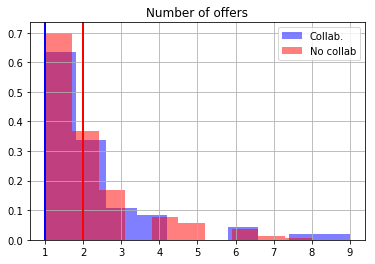

In [1286]:
comparison_hist('offers')
plt.title('Number of offers');

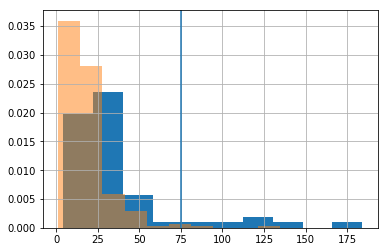

In [1259]:
analyzed_data[analyzed_data['collaboration']==True]['citations_per_paper'].hist(density=True)
analyzed_data[analyzed_data['collaboration']==False]['citations_per_paper'].hist(alpha=0.5, density=True)
plt.axvline(75)

In [1024]:
X=(analyzed_data[analyzed_data['collaboration']==False]).drop(['collaboration','offers','affiliations'],axis=1)

In [1027]:
Y=analyzed_data[analyzed_data['collaboration']==False]['offers']

In [1043]:
X.head()

,affiliations_total,citations_max,citations_median,citations_per_paper,citations_total,papers_last_year,papers_three_years,papers_total,time_since_paper1,time_since_paper2
A.Banerjee.6,1,17.0,6.0,8.800000,44,2,5,5,2.772603,2.027397
A.Bhatta.1,2,38.0,1.5,9.166667,55,3,6,6,3.890411,3.205479
A.Biswas.2,4,55.0,12.0,17.080000,427,3,19,25,8.882192,6.961644
A.Carosso.1,1,16.0,2.0,4.600000,23,2,5,5,1.975342,1.569863
A.Chakraborty.8,2,10.0,5.0,5.142857,36,5,7,7,1.202740,1.150685


In [1048]:
scaler = RobustScaler()

In [1082]:
cross_idx = np.random.choice(len(X),20,replace=False)
train_idx = list(set(np.arange(len(X)))-set(cross_idx))

In [1106]:
scaler.fit(X.iloc[train_idx])
X_scaled = pd.DataFrame(scaler.transform(X.iloc[train_idx]), columns = X.columns)
Y_train = Y.iloc[train_idx]

In [1096]:
X_scaled.head()

,affiliations_total,citations_max,citations_median,citations_per_paper,citations_total,papers_last_year,papers_three_years,papers_total,time_since_paper1,time_since_paper2
0,-0.5,-0.430769,-0.367816,-0.467589,-0.251707,0.0,-0.333333,-0.333333,-0.466896,-0.428358
1,0.0,0.000000,-0.781609,-0.436934,-0.208780,0.5,-0.166667,-0.222222,-0.136465,-0.061072
2,1.0,0.348718,0.183908,0.224658,1.242927,0.5,2.000000,1.888889,1.339137,1.109972
3,-0.5,-0.451282,-0.735632,-0.818729,-0.333659,0.0,-0.333333,-0.333333,-0.702571,-0.571001
4,0.0,-0.574359,-0.459770,-0.773344,-0.282927,1.5,0.000000,-0.111111,-0.930958,-0.701687


In [1146]:
pca_analyzer=PCA(n_components=2)

In [1147]:
pca_analyzer.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5,1,'Variance explained per component of PCA')

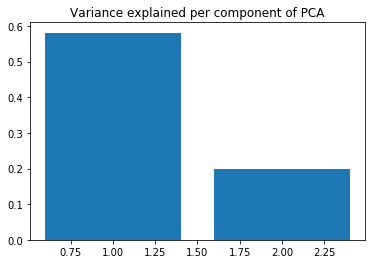

In [1149]:
plt.bar(np.arange(1,3),pca_analyzer.explained_variance_ratio_)
plt.title('Variance explained per component of PCA')